In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

## Données de Température

### Présentation du jeu de données

Dans cette section, nous présentons les données utilisées pour notre analyse de la température. Les données sont initialement dispersées sur un grand nombre de fichiers, un pour chaque département. Ces fichiers contiennent des informations sur la température moyenne mensuelle, mais les données sont incohérentes et nécessitent un nettoyage avant de pouvoir être utilisées efficacement dans nos analyses.



In [27]:
df_climat = pd.read_csv("climat_files/MENSQ_02_previous-1950-2023.csv", delimiter=';', encoding='utf-8')
df_climat.columns

Index(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'AAAAMM', 'RR', 'QRR',
       'NBRR', 'RR_ME',
       ...
       'QNEIGETOTM', 'NEIGETOTAB', 'QNEIGETOTAB', 'NEIGETOTABDAT',
       'NBJNEIGETOT1', 'NBJNEIGETOT10', 'NBJNEIGETOT30', 'NBJGREL', 'NBJORAG',
       'NBJBROU'],
      dtype='object', length=162)

Ce jeu de données représente les valeurs de temperature moyenne/minimal/maximal mensuelles par region pour le département numéro 2 pour les années 1950-2023.

Premier problème rencontré: Pas de colonne "commune" dans le jeu de données 
=> Solution: Liaison avec le NUM_POSTE figurant dans un autre jeu de donnée qui contentient les valeurs de la commune pour chaque numéro de poste. 

In [28]:
df_commune_1 = pd.read_csv('POSTES_MF.csv', delimiter=';', encoding='utf-8')
df_commune_1.columns

Index(['NUM_POSTE', 'NOM_USUEL', 'COMMUNE', 'LIEU_DIT', 'DATOUVR', 'DATFERM',
       'LAT', 'LON', 'LAMBX', 'LAMBY', 'ALTI', 'TYPE_POSTE_ACTUEL'],
      dtype='object')

In [29]:
df_commune_2 = pd.read_csv('POSTES-COMP.csv', delimiter=';', encoding='utf-8')
df_commune_2.columns

Index(['NUM_POSTE', 'NOM_USUEL', 'COMMUNE', 'LIEU_DIT', 'DATOUVR', 'DATFERM',
       'LAT', 'LON', 'LAMBX', 'LAMBY', 'ALTI', 'TYPE_POSTE_ACTUEL'],
      dtype='object')

In [30]:
def process_climat_data(df_climat):
    df_commune = pd.concat([df_commune_1, df_commune_2], ignore_index=True)
    df_commune.drop_duplicates(subset='NOM_USUEL', inplace=True)

    df_climat_merge = pd.merge(df_climat, df_commune[['NOM_USUEL', 'COMMUNE']], on='NOM_USUEL', how='left')

    # Identification des colonnes utiles
    colonnes_utiles = ['COMMUNE', 'AAAAMM', 'TMM', 'TX', 'TN']
    df_clean = df_climat_merge[colonnes_utiles].copy()

    # Suppression des lignes avec des valeurs manquantes
    df_clean.dropna(inplace=True)

    # Reformulation de la colonne des dates
    df_clean['Date'] = pd.to_datetime(df_clean['AAAAMM'], format='%Y%m')

    # Ajout de la colonne 'Saison'
    def get_season(month):
        if month in [12, 1, 2]: return 'Hiver'
        elif month in [3, 4, 5]: return 'Printemps'
        elif month in [6, 7, 8]: return 'Été'
        else: return 'Automne'

    df_clean['Saison'] = df_clean['Date'].dt.month.map(get_season)
    df_clean.drop(columns='AAAAMM', inplace=True)

    # Renommage des colonnes
    df_clean.rename(columns={
        'COMMUNE': 'Commune',
        'TMM': 'Température moyenne mensuelle',
        'TX': 'Température maximale',
        'TN': 'Température minimale'
    }, inplace=True)

    df_clean['Année'] = df_clean['Date'].dt.year

    # Cacul de la température moyenne annuelle
    annual_avg_temp = df_clean.groupby(['Commune', 'Année'])['Température moyenne mensuelle'].mean().reset_index()
    annual_avg_temp.rename(columns={'Température moyenne mensuelle': 'Température moyenne annuelle'}, inplace=True)

    # Calcul des centiles
    centiles = df_clean.groupby(['Commune', 'Année'])['Température moyenne mensuelle'].quantile([0.25, 0.5, 0.75]).unstack().reset_index()
    centiles.rename(columns={0.25: 'Centile_25%', 0.5: 'Centile_50% (Médiane)', 0.75: 'Centile_75%'}, inplace=True)

    df_clean = pd.merge(df_clean, annual_avg_temp, on=['Commune', 'Année'], how='left')
    df_clean = pd.merge(df_clean, centiles, on=['Commune', 'Année'], how='left')

    return df_clean

In [31]:
climat_directory = 'climat_files'
new_climat_directory = 'climat_files_processed'

files = [f for f in os.listdir(climat_directory)]

# Boucle pour traiter chaque fichier
for file in files:

    file_path = os.path.join(climat_directory, file)

    df_climat = pd.read_csv(file_path, delimiter=';', encoding='utf-8')
    
    processed_data = process_climat_data(df_climat)
    
    output_file = os.path.join(new_climat_directory, f"processed_{file}")
    
    processed_data.to_csv(output_file, index=False)
    
    print(f"Processed file saved as: {output_file}")


Processed file saved as: climat_files_processed/processed_MENSQ_82_previous-1950-2023.csv
Processed file saved as: climat_files_processed/processed_MENSQ_43_previous-1950-2023.csv
Processed file saved as: climat_files_processed/processed_MENSQ_36_previous-1950-2023.csv
Processed file saved as: climat_files_processed/processed_MENSQ_88_previous-1950-2023.csv
Processed file saved as: climat_files_processed/processed_MENSQ_49_previous-1950-2023.csv
Processed file saved as: climat_files_processed/processed_MENSQ_78_previous-1950-2023.csv
Processed file saved as: climat_files_processed/processed_MENSQ_07_previous-1950-2023.csv
Processed file saved as: climat_files_processed/processed_MENSQ_72_previous-1950-2023.csv
Processed file saved as: climat_files_processed/processed_MENSQ_85_previous-1950-2023.csv
Processed file saved as: climat_files_processed/processed_MENSQ_44_previous-1950-2023.csv
Processed file saved as: climat_files_processed/processed_MENSQ_31_previous-1950-2023.csv
Processed 

In [32]:
df_test = pd.read_csv('climat_files_processed/processed_MENSQ_02_previous-1950-2023.csv', delimiter=',', encoding='utf-8')
df_test.columns

Index(['Commune', 'Température moyenne mensuelle', 'Température maximale',
       'Température minimale', 'Date', 'Saison', 'Année',
       'Température moyenne annuelle', 'Centile_25%', 'Centile_50% (Médiane)',
       'Centile_75%'],
      dtype='object')

In [33]:
merged_df = []

# Merge des fichiers traités
def extract_department_from_filename(filename):
    match = re.search(r'processed_MENSQ_(\d{2})_', filename)
    return match.group(1) if match else None

for file in os.listdir(new_climat_directory):
    if file.endswith(".csv") and file.startswith("processed_MENSQ_"):
        file_path = os.path.join(new_climat_directory, file)
        df = pd.read_csv(file_path)

        # Ajout de la colonne 'Département'
        dept = extract_department_from_filename(file)
        df['Département'] = dept

        merged_df.append(df)

# Concatenation de tous les fichiers traités et filtrage pour ne garder que les années >= 2018
final_df = pd.concat(merged_df, ignore_index=True)
final_df = final_df[final_df['Année'] >= 2018]

final_df.to_csv('climat_merged_all_departments.csv', index=False)
print("Merged file saved as: climat_merged_all_departments.csv")


/var/folders/__/d39q8d5n2k71j82c7ngscbp40000gn/T/ipykernel_17734/1058527133.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(merged_df, ignore_index=True)


Merged file saved as: climat_merged_all_departments.csv


In [34]:
final_df

,Commune,Température moyenne mensuelle,Température maximale,Température minimale,Date,Saison,Année,Température moyenne annuelle,Centile_25%,Centile_50% (Médiane),Centile_75%,Département
52,BAYEUX,7.9,10.4,5.5,2018-01-01,Hiver,2018,11.708333,8.125,12.35,15.70,14
53,BAYEUX,3.9,6.8,1.1,2018-02-01,Hiver,2018,11.708333,8.125,12.35,15.70,14
54,BAYEUX,6.9,10.8,4.1,2018-03-01,Printemps,2018,11.708333,8.125,12.35,15.70,14
55,BAYEUX,11.7,16.3,7.9,2018-04-01,Printemps,2018,11.708333,8.125,12.35,15.70,14
56,BAYEUX,13.4,18.0,9.1,2018-05-01,Printemps,2018,11.708333,8.125,12.35,15.70,14
...,...,...,...,...,...,...,...,...,...,...,...,...
498675,SUBLAINES,20.1,25.5,15.2,2023-08-01,Été,2023,13.383333,8.800,12.75,20.15,37
498676,SUBLAINES,20.5,27.3,14.9,2023-09-01,Automne,2023,13.383333,8.800,12.75,20.15,37
498677,SUBLAINES,15.1,20.6,10.4,2023-10-01,Automne,2023,13.383333,8.800,12.75,20.15,37
498678,SUBLAINES,9.4,12.7,6.8,2023-11-01,Automne,2023,13.383333,8.800,12.75,20.15,37


## Visualisations de la Température en fonction de la Consommation Électrique
### 1. Histogramme de la Consommation Énergétique en Fonction des Intervalles de Température


In [35]:
df_all = pd.read_csv('data-final-02_04.csv')

In [36]:
print(df_all['Température moyenne annuelle'].describe())


count    90016.000000
mean        14.266707
std          2.144456
min          2.500000
25%         12.691667
50%         14.100000
75%         16.058333
max         19.947917
Name: Température moyenne annuelle, dtype: float64


/var/folders/__/d39q8d5n2k71j82c7ngscbp40000gn/T/ipykernel_17734/1111536877.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_consumption = df_all.groupby('Temp_binned')["Consommation annuelle moyenne par logement de l'adresse (MWh)"].mean()


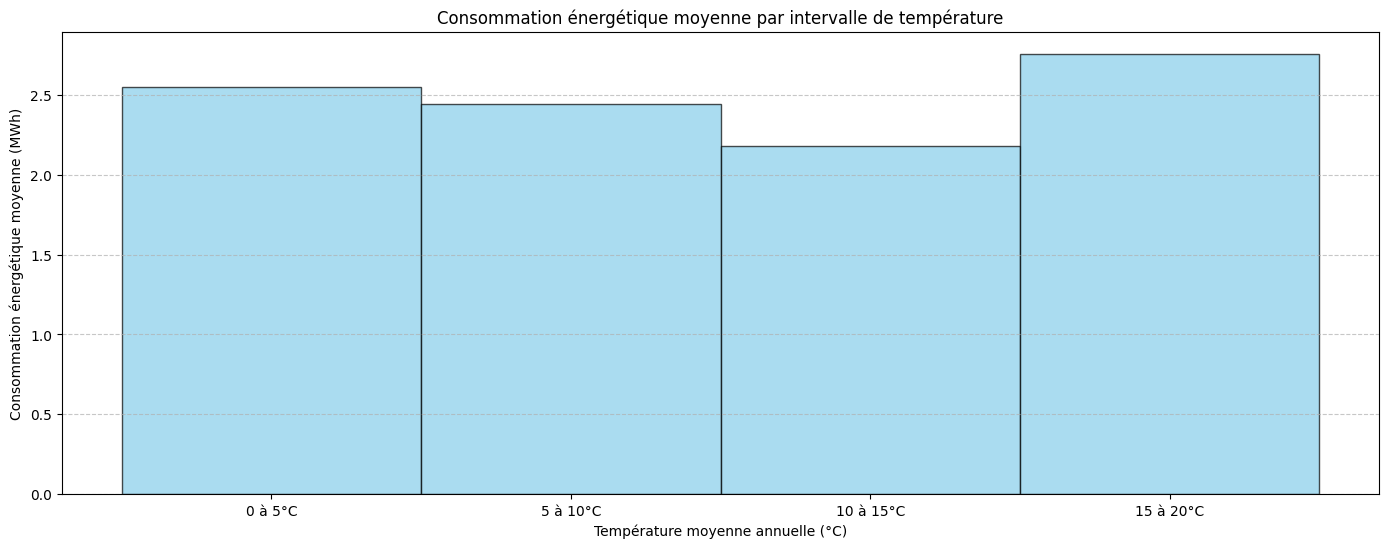

In [37]:
bins = [0, 5, 10, 15, 20] 

df_all['Temp_binned'] = pd.cut(df_all['Température moyenne annuelle'], bins, right=True)

avg_consumption = df_all.groupby('Temp_binned')["Consommation annuelle moyenne par logement de l'adresse (MWh)"].mean()

full_bin_index = pd.IntervalIndex.from_breaks(bins)
avg_consumption = avg_consumption.reindex(full_bin_index)

bin_centers = [interval.mid for interval in full_bin_index]
plt.figure(figsize=(17, 6))
plt.bar(bin_centers, avg_consumption.fillna(0), width=5, edgecolor='black', color='skyblue', alpha=0.7)

plt.title("Consommation énergétique moyenne par intervalle de température")
plt.xlabel("Température moyenne annuelle (°C)")
plt.ylabel("Consommation énergétique moyenne (MWh)")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(bin_centers, [f"{int(i.left)} à {int(i.right)}°C" for i in full_bin_index])
plt.show()


L'histogramme montre la **consommation énergétique moyenne** par logement en fonction des **intervalles de température mensuelle moyenne**.

- La consommation semble **élevée quand les températures sont très basses (< 0°C)**, ce qui est cohérent avec une **augmentation du chauffage**.
- On observe aussi une hausse pour les températures très élevées (> 25°C), probablement liée à **l'utilisation de la climatisation**.
- Les intervalles centraux (10°C–20°C) affichent une consommation plus basse, ce qui peut correspondre à une période sans chauffage ni climatisation.


### 2. Heatmap de la Corrélation entre Température et Consommation d'Énergie

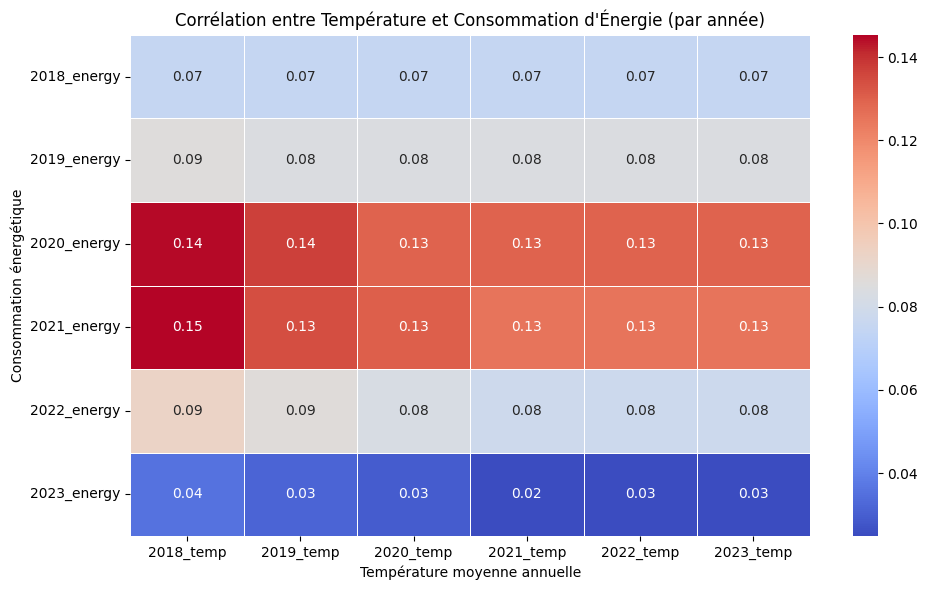

In [38]:
# Calcul de la matrice de corrélation
heatmap_data = df_all.pivot_table(index='Nom Commune', columns='Année_x', values='Température moyenne annuelle')
heatmap_energy = df_all.pivot_table(index='Nom Commune', columns='Année_x', values="Consommation annuelle moyenne par logement de l'adresse (MWh)")

combined_data = heatmap_data.add_suffix('_temp').join(heatmap_energy.add_suffix('_energy'))

corr = combined_data.corr()

temp_cols = [col for col in corr.columns if '_temp' in col]
energy_cols = [col for col in corr.columns if '_energy' in col]
corr_focus = corr.loc[energy_cols, temp_cols]

# Affichage
plt.figure(figsize=(10, 6))
sns.heatmap(corr_focus, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Corrélation entre Température et Consommation d'Énergie (par année)")
plt.xlabel("Température moyenne annuelle")
plt.ylabel("Consommation énergétique")
plt.tight_layout()
plt.show()


Le **heatmap** ci-dessus montre la **corrélation** entre la **température moyenne mensuelle** et la **consommation énergétique annuelle moyenne par logement** pour chaque année permettant de comprendre si la température a un impact significatif sur la consommation d'énergie. 

Les valeurs vont de **0.02 à 0.15**, indiquant une **corrélation faible** dans l'ensemble.

En effet, on peut conclure que le graphique montre que **la température a une influence limitée** sur la consommation d'énergie. Bien qu'il existe des corrélations faibles, elles ne sont pas suffisamment fortes pour suggérer que la température soit le facteur principal influençant la consommation d'énergie. Cela confirme l'hypothèse qu'il existe probablement **d'autres facteurs** qui influencent davantage la consommation énergétique. 